In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import timm
import timm.optim as tiopt

from torch.utils.data import DataLoader

In [2]:
# 設置設備（GPU如果可用，否則使用CPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 數據預處理和加載
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

net = timm.create_model('resnet18',num_classes=10).to(device)

In [4]:
# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = tiopt.Lookahead(optim.AdamW(net.parameters(), lr=0.0001))

In [5]:
# 訓練模型
confidence = {}
correctness = {}
print("Start training")
epochs = 20
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{epochs}], loss: {running_loss / len(trainloader):.3f}')

    # EVALUATE
    net.eval()
    confidence_list = []
    correctness_list = []

    with torch.no_grad():
        temp_outputs = np.array([])
        temp_groundtruth = np.array([])
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            probs = F.softmax(outputs, dim=1)

            # add to temp_outputs and temp_groundtruth
            temp_outputs = np.concatenate((temp_outputs, np.argmax(probs.cpu().numpy(), axis=1)))
            temp_groundtruth = np.concatenate((temp_groundtruth, labels.cpu().numpy()))

            for i in range(len(probs)):
                confidence_list.append(probs[i][labels[i]].item())

        correctness_list = (temp_outputs == temp_groundtruth).astype(int)

    confidence[epoch] = confidence_list
    correctness[epoch] = correctness_list

print('Finished Training')

Start training


AssertionError: Input height (32) doesn't match model (224).

In [ ]:
# 在測試集上評估模型
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 60.9%


Confidence list shape: (50000, 20)
Correctness list shape: (50000, 20)


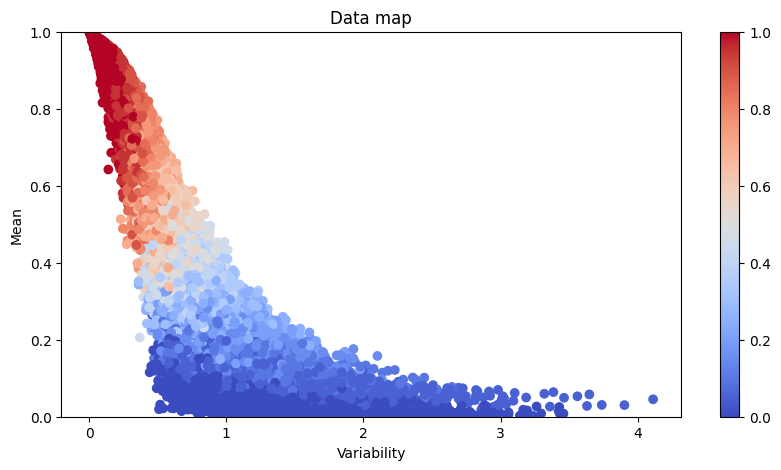

In [ ]:
confidence_list = [[] for _ in range(len(confidence[0]))]
correctness_list = [[] for _ in range(len(correctness[0]))]
for epoch in confidence:
    for i in range(len(confidence[epoch])):
        confidence_list[i].append(confidence[epoch][i])

for epoch in correctness:
    for i in range(len(correctness[epoch])):
        correctness_list[i].append(correctness[epoch][i])

confidence_list = np.array(confidence_list)
correctness_list = np.array(correctness_list)
print(f"Confidence list shape: {confidence_list.shape}")
print(f"Correctness list shape: {correctness_list.shape}")

mean = np.mean(confidence_list, axis=1)
std = np.std(confidence_list, axis=1)
variability = std / mean

correctness_mean = np.mean(correctness_list, axis=1)

# plot mean and variability (dot plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(variability, mean, c=correctness_mean, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Variability')
plt.ylabel('Mean')
plt.ylim(0, 1)
plt.title('Data map')
plt.savefig('data_map.png')

type A: 0 < correctness <= 0.4 and 0 < mean <= 0.2 and 0 < variance <= 0.2 </br>
type B: 0.4 < correctness <= 0.6 and 0.2 < mean <= 0.6 and 0.2 < variance <= 0.6 </br>
type C: 0.6 < correctness <= 1 and 0.6 < mean <= 1 and 0.6 < variance <= 1 </br>

In [ ]:
# Segmentation data
# type A: 0 < correctness <= 0.4 and 0 < mean <= 0.2 and 0 < variance <= 0.2 </br>
# type B: 0.4 < correctness <= 0.6 and 0.2 < mean <= 0.6 and 0.2 < variance <= 0.6 </br>
# type C: 0.6 < correctness <= 1 and 0.6 < mean <= 1 and 0.6 < variance <= 1 </br>

from tqdm import tqdm

type_A = []
type_B = []
type_C = []

for i in tqdm(range(len(mean))):
    if mean[i] <= 0.2 and correctness_mean[i] <= 0.4:
        type_A.append(i)
    elif mean[i] <= 0.6 and correctness_mean[i] <= 0.6:
        type_B.append(i)
    else:
        type_C.append(i)

100%|██████████| 50000/50000 [00:00<00:00, 3959804.38it/s]


In [ ]:
len(type_A), len(type_B), len(type_C)

(6622, 10492, 32886)

In [ ]:
# if is odd, remove the last one
if len(type_A) % 2 != 0:
    type_A.pop()
if len(type_B) % 2 != 0:
    type_B.pop()
if len(type_C) % 2 != 0:
    type_C.pop()

In [ ]:
type_A = np.array(type_A)
type_B = np.array(type_B)
type_C = np.array(type_C)

# to data loader
from torch.utils.data import Subset

type_A_loader = DataLoader(Subset(trainset, type_A), batch_size=2, shuffle=False)
type_B_loader = DataLoader(Subset(trainset, type_B), batch_size=2, shuffle=False)
type_C_loader = DataLoader(Subset(trainset, type_C), batch_size=2, shuffle=False)

In [ ]:
new_models = {}

for idx, loader in enumerate([type_A_loader, type_B_loader, type_C_loader]):
    new_model = timm.create_model('resnet18',num_classes=10).to(device)
    optimizer = tiopt.Lookahead(optim.AdamW(new_model.parameters(), lr=0.0001))

    print(f"Start training model {idx}")
    epochs = 20
    for epoch in range(epochs):
        new_model.train()
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{epochs}], loss: {running_loss / len(loader):.3f}')
    
    new_models[idx] = new_model

    print(f'Finished Training model {idx}')

Start training model 0
Epoch [1/20], loss: 2.162
Epoch [2/20], loss: 2.141
Epoch [3/20], loss: 2.137
Epoch [4/20], loss: 2.131
Epoch [5/20], loss: 2.125
Epoch [6/20], loss: 2.121
Epoch [7/20], loss: 2.118
Epoch [8/20], loss: 2.119
Epoch [9/20], loss: 2.116
Epoch [10/20], loss: 2.114
Epoch [11/20], loss: 2.112
Epoch [12/20], loss: 2.112
Epoch [13/20], loss: 2.103
Epoch [14/20], loss: 2.107
Epoch [15/20], loss: 2.102
Epoch [16/20], loss: 2.101
Epoch [17/20], loss: 2.100
Epoch [18/20], loss: 2.100
Epoch [19/20], loss: 2.092
Epoch [20/20], loss: 2.089
Finished Training model 0
Start training model 1
Epoch [1/20], loss: 2.231
Epoch [2/20], loss: 2.204
Epoch [3/20], loss: 2.195
Epoch [4/20], loss: 2.187
Epoch [5/20], loss: 2.179
Epoch [6/20], loss: 2.170
Epoch [7/20], loss: 2.162
Epoch [8/20], loss: 2.155
Epoch [9/20], loss: 2.151
Epoch [10/20], loss: 2.146
Epoch [11/20], loss: 2.131
Epoch [12/20], loss: 2.123
Epoch [13/20], loss: 2.115
Epoch [14/20], loss: 2.109
Epoch [15/20], loss: 2.103
E

In [ ]:
new_models

{0: ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (act1): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (drop_block): Identity()
       (act1): ReLU(inplace=True)
       (aa): Identity()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (act2): ReLU(inplace=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchN

In [ ]:
class Chimera(nn.Module):
    def __init__(self, models):
        super(Chimera, self).__init__()
        self.models = models
        # 假設每個模型的輸出維度為10
        self.adp = nn.AdaptiveAvgPool2d((32,16))
        self.final_cnn = timm.create_model('resnet18',num_classes=10)

    def forward(self, x):
        outputs = []
        with torch.no_grad():
            for model in self.models:
                model.eval()
                outputs.append(model.forward_features(x))
        x = torch.stack(outputs, dim=1) # (batch_size, num_models, feature_size)
        x = x.squeeze(-1)
        x = self.adp(x)
        x = self.final_cnn(x)
        return x
    
chimera = Chimera([new_models[0], new_models[1], new_models[2]]).to(device)
test_inputs, test_labels = next(iter(testloader))
test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
chimera(test_inputs).shape, test_labels.shape

(torch.Size([4, 10]), torch.Size([4]))

In [ ]:
# final training
optimizer = tiopt.Lookahead(optim.AdamW(chimera.parameters(), lr=0.0001))

print("Start training chimera")

epochs = 20
for epoch in range(epochs):
    chimera.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = chimera(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{epochs}], loss: {running_loss / len(trainloader):.3f}')

print('Finished Training chimera')

# 在測試集上評估模型
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = chimera(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Start training chimera
Epoch [1/20], loss: 1.955
Epoch [2/20], loss: 1.785
Epoch [3/20], loss: 1.704
Epoch [4/20], loss: 1.632
Epoch [5/20], loss: 1.557
Epoch [6/20], loss: 1.473
Epoch [7/20], loss: 1.371
Epoch [8/20], loss: 1.244
Epoch [9/20], loss: 1.098
Epoch [10/20], loss: 0.946
Epoch [11/20], loss: 0.802
Epoch [12/20], loss: 0.685
Epoch [13/20], loss: 0.589
Epoch [14/20], loss: 0.516
Epoch [15/20], loss: 0.471
Epoch [16/20], loss: 0.430
Epoch [17/20], loss: 0.395
Epoch [18/20], loss: 0.373
Epoch [19/20], loss: 0.350
Epoch [20/20], loss: 0.325
Finished Training chimera
Accuracy of the network on the 10000 test images: 34.08%
